---
# Lecture 7: Molecular Dynamics Simulations in Python
---

## 1. Introduction <a id='l_overview'></a>

This lecture was created as part of a CPS Teaching Fellowship. We are introducing a novel approach to study advanced scientific programming. The goal of today's lecture is to present Molecular Dynamics (MD) simulations of macromolecules. We will learn how to run these simulations using the Python programmming language. We will use many `numpy` functions and a few new modules, such as `openmm` for MD simulations. These are the important concepts that we will cover:

- [Newton's Laws of Motion](#l_newton) 
- [Simulation of Dynamics of Particles](#l_sims)
- [Proteins -- Different Levels of Structure](#l_proteins)
- [Molecular Mechanics](#l_mm)
- [MD Simulations of Proteins](#l_md)


## 2. Newton's Laws of Motion <a id='l_newton'></a>

Newton's 2nd law connects the kinematics (movements) of a body with its mechanics (total force acting on it) and defines the dynamic evolution of its position: 

$$m\frac{d^2r(t)}{dt^2} = F = - \nabla{U(r)},$$

where $m$ is the mass, $r$ is the position, $F$ is the force and $U(r)$ is the potential energy, which depends only on the position of the body. 
If one knows the forces acting upon the body, one can find the position of the body at any moment $r(t)$, i.e. predict its dynamics. This can be done by solving Newton's equation of motion. It is a second order ODE that can be solved analytically for a few simple cases: constant force, harmonic oscillator, periodic force, drag force, etc.
However, a more general approach is to use computers in order to solve the ODE numerically.


## 3. Simulation of Dynamics of Particles <a id='l_sims'></a>

There are [many methods](https://en.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Methods) for solving ODEs. The second order ODE is transformed to the system of two first order ODEs as follows:

$$\frac{dr(t)}{dt} = v(t)$$

$$m\frac{dv(t)}{dt} = F(t)$$

We use a finite difference approximation that comes to a simple forward Euler Algorithm: 

$$ v_{n+1} = v_n + \frac{F_n}{m} dt$$

$$ r_{n+1} = r_n + v_{n+1} dt$$

Here we discretize time t with time step $dt$, so $t_{n+1} = t_n + dt$, and $r_{n} = r(t_n)$, $v_{n} = v(t_n)$, where $n$ is the timestep number. Using this method, computing dynamics is straightforward.


<img src="pics/Toronto-04.png" width="300" align="right">
### Example 3.1. Simulation of a projectile on Earth.
---

We want to know the dynamics of a green apple ($m = 0.3$ kg) tossed horizontally at 10 cm/s speed from the top of the Toronto CN Tower (553 m) for the first 10 seconds.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Setup the figure and axes...
fig, ax = plt.subplots(figsize=(8,8))

## Adjust axes limits according to your problem. Here we don't need more than a couple of meters left or right, and 600 meters up
ax.set(xlim=(-2, 2), ylim=(0, 600), xlabel='Position, meters', ylabel='Height, meters', title='Apple falling from CN tower')

# parameters of the problem
T = 10. #s
m = 0.3 #kg
g = 9.8 #m/s^2
v0x = -0.1 #m/s
H = 553. #m

# setting a timestep to be 50 ms
dt = 0.05 #s
N = int(T / dt)

# Allocating arrays for 2D problem
v = np.zeros((N+1, 2))
r = np.zeros((N+1, 2))
f = np.zeros((N+1, 2))

# initial conditions:
r[0] = np.array([0., H])
v[0] = np.array([-v0x, 0.])

# the only force is gravity
f[:] = np.array([0., -m * g])

## Run dynamics:
for n in range(N):
    v[n+1] = v[n] + f[n]/m * dt
    r[n+1] = r[n] + v[n+1] * dt

## drawing the first data point  
scat = ax.scatter(r[0,0], r[0,1], marker='o', c='g', s=200)

## animating 
def animate(i):
    scat.set_offsets(r[i])

ani = animation.FuncAnimation(fig, func=animate, frames=N)
## this function will create a lot of *.png files in a folder 'CNtower_frames'
## and create an HTML page with a simulation
ani.save('CNtower.html', writer=animation.HTMLWriter(fps= 1//dt))
plt.close()
#ani.save('CNtower.mp4', fps= 1//dt)

Let's visualize the dynamics using embedded HTML. It's interactive and you can play a movie step by step:

In [2]:
from IPython.display import HTML
HTML('CNtower.html')

---
When a closed system of particles are interacting through pairwise potentials, the force on each particle $i$ depends on its position with respect to every other particle $j$:

$$m_i\frac{d^2r_i(t)}{dt^2} = \sum_jF_{ij}(t) = -\sum_j\nabla_i{U(|r_{ij}(t)|)}$$

where $r_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2 + (z_i - z_j)^2}$ is the distance between particle $i$ and $j$, and $i,j \in (1,N)$.

### Example 3.2. Simulation of 3-body problem with Hooke's law:

We want to know the dynamics of 3 particles $m = 1$ kg connected to each other with invisible springs with $K_s = 5$ N/m, and $r_0 = 1$ m initially located at (0, 2), (2, 0) and (-1, 0) on the 2D plane for the first 10 seconds of their motion.

**Hint:**
The pairwise potential is (Hooke's Law): $$U(r_{ij}) = \frac{K_s}{2}(r_{ij} - r_0)^2$$

The negative gradient of the potential is a force from $j$-th upon $i$-th: 

$$\mathbf{F_{ij}} = - \nabla_i{U(r_{ij})} = - K_s (r_{ij} - r_0) \nabla_i r_{ij} = - K_s (r_{ij} - r_0) \mathbf{r_{ij}} / r_{ij}$$


In [3]:
# Setup the figure and axes...
fig, ax = plt.subplots(figsize=(6,6))
ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), ylabel='meters', xlabel='meters', title='3-Body problem')

# parameters of the problem
T = 10. #s
m = 1.0 #kg
ks = 5 #N/m
r0 = 1. #m

# setting a timestep to be 50 ms
dt = 0.05 #s
N = int(T / dt)

# Allocating arrays for 2D problem: first axis - time. second axis - particle's number. third - coordinate
v = np.zeros((N+1, 3, 2))
r = np.zeros((N+1, 3, 2))
f = np.zeros((N+1, 3, 2))

# initial conditions for 3 particles:
r[0,0] = np.array([0., 2.])
r[0,1] = np.array([2., 0.])
r[0,2] = np.array([-1., 0.])

def compute_forces(n):
    '''The function computes forces on each pearticle at time step n'''
    for i in range(3):
        for j in range(3):
            if i != j:
                rij = r[n,i] - r[n,j]
                rij_abs = np.linalg.norm(rij)
                f[n, i] -= ks * (rij_abs - r0) * rij / rij_abs 
## Run dynamics:
for n in range(N):
    compute_forces(n)
    v[n+1] = v[n] + f[n]/m * dt
    r[n+1] = r[n] + v[n+1] * dt

## drawing and animating 
scat = ax.scatter(r[0,:,0], r[0,:,1], marker='o', c=['b', 'k', 'r'], s=1000)

def animate(i):
    scat.set_offsets(r[i])

ani = animation.FuncAnimation(fig, animate, frames=N)
plt.close()
## this function will create a lot of *.png files in a folder '3Body_frames'
ani.save('3body.html', writer=animation.HTMLWriter(fps= 1//dt))

Again, looking at the trajectory representation in real time:

In [4]:
HTML('3body.html')

While we now have a basic knowledge of the purpose and methodology of simulations, we still need to understand what proteins are and why they are important.

---
## 4. Proteins, structure and functions <a id='l_proteins'></a>
---
<img src="pics/Protein_structure.png" width="400" align="right">

[Protein structure](https://en.wikipedia.org/wiki/Protein_structure) is the three-dimensional arrangement of atoms in a protein, which is a chain of amino acids. Proteins are polymers – specifically polypeptides – formed from sequences of 20 types of amino acids, the monomers of the polymer. A single amino acid monomer may also be called a residue, indicating a repeating unit of a polymer. To be able to perform their biological function, proteins fold into one or more specific spatial conformations driven by a number of non-covalent interactions such as:

- hydrogen bonding 
- ionic interactions 
- Van der Waals forces
- hydrophobic packing 

To understand the functions of proteins at a molecular level, it is often necessary to determine their three-dimensional structure using techniques such as X-ray crystallography, NMR spectroscopy, and others.

### 4.1 Levels of structure:

**Primary structure** of a protein refers to the sequence of amino acids in the polypeptide chain.

**Secondary structure** refers to highly regular local sub-structures of the actual polypeptide backbone chain. There are two main types of secondary structure: the α-helix and the β-strand or β-sheets.

**Tertiary structure** refers to the three-dimensional structure of monomeric and multimeric protein molecules. The α-helixes and β-sheets are folded into a compact globular structure. 

**Quaternary structure** is the three-dimensional structure consisting of two or more individual polypeptide chains (subunits) that operate as a single functional unit (multimer).


### 4.2 Functions:

- *Antibodies* - bind to specific foreign particles, ex: IgG 
- *Enzymes* - speed up chemical reactions, ex: Lysozyme
- *Messengers* - transmit signals, ex: Growth hormone 
- *Structural components* - support for cells, ex: Tubulin
- *Transport/storage* - bind and carry small molecules, ex: Hemoglobin


**Lysozyme** is a protein-enzyme (found in tears, saliva, mucus and egg white) that is a part of the innate immune system with antimicrobial activity characterized by the ability to damage the cell wall of bacteria. Bacteria have polysaccharides (sugars) in their cell wall, that bind to the groove, and lysozyme cuts the bond and destroys bacteria.  

|  ![Protein Sequence in DNA](pics/LysozymeSequence.png) | ![Protein Structure](pics/LysozymeStructure.gif) | ![Protein Strucure with Sugar](pics/LysozymeRock.gif) |
|:-:|:-:|:-:|
|  Sequence | Structure | Function  |

Figure credit: [C.Ing](https://github.com/cing/HackingStructBiolTalk) and [wikipedia](https://en.wikipedia.org/wiki/Protein_structure)


---
## 5. Molecular Mechanics <a id='l_mm'></a>
---

Since we now know what proteins are and why these molecular machines are important, we consider the method to model them. The basic idea is to create the same kind of approach as we used in the 3-body simulation. Now, our system consists of thousands particles (atoms of the protein plus atoms of surrounding water) and they all are connected via a complex potential energy function.

An all-atom potential energy function $V$ is usually given by the sum of the bonded terms ($V_b$) and non-bonded terms ($V_{nb}$), i.e.

$$V = V_{b} + V_{nb},$$

where the bonded potential includes the harmonic (covalent) bond part, the harmonic angle and
the two types of torsion (dihedral) angles: proper and improper. As it can be seen, these functions are mostly harmonic potentials 

$$V_{b} = \sum_{bonds}\frac{1}{2}K_b(b-b_0)^2 + \sum_{angles}K_{\theta}(\theta-\theta_0)^2 + \sum_{dihedrals}K_{\phi}(1-cos(n\phi - \phi_0)) + \sum_{impropers}K_{\psi}(\psi-\psi_0)^2$$

For example, $b$ and $\theta$ represent the distance between two atoms and the angle between two
adjacent bonds; $\phi$ and $\psi$ are dihedral (torsion) angles. These can be evaluated for all the
atoms from their current positions. Also, $K_b$, $K_\theta$, $K_\phi$, and $K_\psi$ are the spring constants, associated
with bond vibrations, bending of bond angles, and conformational fluctuations in dihedral and
improper angles around some equilibrium values $b_0$, $\theta_0$, $\phi_0$, and $\psi_0$, respectively. 

The non-bonded part of the potential energy function is represented by the electrostatic and van der Waals potentials, i.e.

$$V_{nb} = \sum_{i,j}\left(\frac{q_{i}q_{j}}{4\pi\varepsilon_{0}\varepsilon r_{ij}} + \varepsilon_{ij}\left[\left(\frac{\sigma^{min}_{ij}}{r_{ij}}\right)^{12}-2\left(\frac{\sigma^{min}_{ij}}{r_{ij}}\right)^{6}\right]\right)$$

where $r_{ij}$ is the distance between two interacting atoms, $q_i$ and $q_j$ are their electric charges; $\varepsilon$ and
$\varepsilon_0$ are electric and dielectric constant; $\varepsilon_{ij} = \sqrt{\varepsilon_i\varepsilon_j}$ and
$\sigma_{ij} = \frac{\sigma_i + \sigma_j}{2}$ are van der Waals parameters for atoms $i$ and $j$.

**Importantly, each force field has its own set of parameters, which are different for different types of atoms.**

![](pics/ff.png)


## 6. Molecular dynamics of proteins <a id='l_md'></a>
---

[**Molecular dynamics (MD)**](https://en.wikipedia.org/wiki/Molecular_dynamics) is a computer simulation method for studying the physical movements of atoms and molecules, i.e. their dynamical evolution. 

In the most common version, the trajectories of atoms and molecules are determined by numerically solving Newton's equations of motion for a system of interacting particles, where forces between the particles and their potential energies are often calculated using  [molecular mechanics force fields](#l_mm). 



Now with all that intellectual equipment, we can start running legit Molecular Dynamics simulations. All we need is an initial structure of the protein and software that computes its dynamics efficiently.


### Procedure:
1. Load initial coordinates of protein atoms (from `*.pdb` file)
2. Choose force field parameters (in potential function V from section 5).
3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions
4. Choose integrator, i.e. algorithm for solving equation of motion
5. Run simulation, save coordinates time to time (to `*.dcd` file).
6. Visualize the trajectory 
7. Perform the analysis

These are the Python libraries we are going to need today:

1. [nglview](http://nglviewer.org/nglview/latest/index.html#installation) - module to visualize molecules
2. [mdanalysis](https://www.mdanalysis.org/pages/installation_quick_start/) - module to analyze MD trajectory
3. [openmm](http://docs.openmm.org/latest/userguide/application.html#installing-openmm) - module to run MD simulation

In [2]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import MDAnalysis as md
import nglview as ng
from sys import stdout

These files are already preloaded to your `data` folder.

In [3]:
pdb0_file = 'data/villin_water.pdb'
pdb1_file = 'data/polyALA.pdb'
pdb2_file = 'data/polyGLY.pdb'
pdb3_file = 'data/polyGV.pdb'

PDB files contain 3D structures of proteins that were resolved by experimental techniques. They can be downloaded from [ProteinDataBank](https://www.wwpdb.org/). Here we can see what a `.pdb` file looks like: 

In [4]:
file0 = open(pdb0_file, 'r')
for line in file0:
    print(line)

REMARK    GENERATED BY TRJCONV

HEADER    Villin N68H in explicit water

REMARK    THIS IS A SIMULATION BOX

CRYST1   49.163   45.981   38.869  90.00  90.00  90.00 P 1           1

MODEL        0

ATOM      1  N   LEU     1      25.160  14.160  19.440  1.00  0.00

ATOM      2  H1  LEU     1      24.350  13.730  19.870  1.00  0.00

ATOM      3  H2  LEU     1      25.980  13.680  19.760  1.00  0.00

ATOM      4  H3  LEU     1      25.180  15.100  19.810  1.00  0.00

ATOM      5  CA  LEU     1      25.090  13.920  17.980  1.00  0.00

ATOM      6  HA  LEU     1      24.700  12.930  17.760  1.00  0.00

ATOM      7  CB  LEU     1      24.420  14.970  17.100  1.00  0.00

ATOM      8  HB1 LEU     1      24.590  14.630  16.080  1.00  0.00

ATOM      9  HB2 LEU     1      24.950  15.910  17.240  1.00  0.00

ATOM     10  CG  LEU     1      22.930  15.010  17.400  1.00  0.00

ATOM     11  HG  LEU     1      22.870  15.610  18.310  1.00  0.00

ATOM     12  CD1 LEU     1      22.410  15.830  16.210 


ATOM   4454  HW2 HOH  1327      18.340  39.570  30.260  1.00  0.00

ATOM   4455  OW  HOH  1328      13.380  38.340  30.950  1.00  0.00

ATOM   4456  HW1 HOH  1328      13.580  38.820  30.150  1.00  0.00

ATOM   4457  HW2 HOH  1328      13.050  39.000  31.560  1.00  0.00

ATOM   4458  OW  HOH  1329      10.440  23.140  30.330  1.00  0.00

ATOM   4459  HW1 HOH  1329      11.020  22.400  30.480  1.00  0.00

ATOM   4460  HW2 HOH  1329      10.840  23.620  29.610  1.00  0.00

ATOM   4461  OW  HOH  1330       2.580  42.590   3.230  1.00  0.00

ATOM   4462  HW1 HOH  1330       2.540  43.060   2.400  1.00  0.00

ATOM   4463  HW2 HOH  1330       3.410  42.110   3.200  1.00  0.00

ATOM   4464  OW  HOH  1331      24.030  25.490   0.570  1.00  0.00

ATOM   4465  HW1 HOH  1331      24.050  26.440   0.710  1.00  0.00

ATOM   4466  HW2 HOH  1331      24.710  25.330  -0.090  1.00  0.00

ATOM   4467  OW  HOH  1332       5.990  30.430  25.230  1.00  0.00

ATOM   4468  HW1 HOH  1332       5.190  30.310 

ATOM   8453  HW2 HOH  2660       1.860  22.850   5.030  1.00  0.00

ATOM   8454  OW  HOH  2661      48.410  32.990  30.680  1.00  0.00

ATOM   8455  HW1 HOH  2661      49.000  32.890  29.930  1.00  0.00

ATOM   8456  HW2 HOH  2661      47.570  32.650  30.360  1.00  0.00

ATOM   8457  OW  HOH  2662       2.350  35.390  23.530  1.00  0.00

ATOM   8458  HW1 HOH  2662       2.350  35.290  24.480  1.00  0.00

ATOM   8459  HW2 HOH  2662       1.540  35.870  23.330  1.00  0.00

ATOM   8460  OW  HOH  2663      12.900   7.970  18.710  1.00  0.00

ATOM   8461  HW1 HOH  2663      13.770   7.660  18.950  1.00  0.00

ATOM   8462  HW2 HOH  2663      12.830   7.780  17.770  1.00  0.00

ATOM   8463  OW  HOH  2664       8.910  32.110   9.210  1.00  0.00

ATOM   8464  HW1 HOH  2664       9.390  32.930   9.080  1.00  0.00

ATOM   8465  HW2 HOH  2664       8.270  32.090   8.500  1.00  0.00

ATOM   8466  OW  HOH  2665      44.950  29.690  35.870  1.00  0.00

ATOM   8467  HW1 HOH  2665      45.330  30.440  

We can look at the protein via `nglview`:

In [5]:
u = md.Universe(pdb0_file)
ng.show_mdanalysis(u, gui=True)

NGLWidget()

### Example 6.1. MD simulation of protein folding into alpha-helix
---

Run a simulation of fully extended polyalanine `polyALA.pdb` for 400 picoseconds in a vacuo environment with T=300 K and see if it can fold to any secondary  structure:

In [6]:
### 1.loading initial coordinates
pdb = PDBFile(pdb3_file) 

### 2.choosing a forcefield parameters
ff = ForceField('amber10.xml')  
system = ff.createSystem(pdb.topology, nonbondedMethod=CutoffNonPeriodic)

### 3. Choose parameters of the experiment: temperature, pressure, box size, solvation, boundary conditions, etc
temperature = 300*kelvin
frictionCoeff = 1/picosecond
time_step = 0.002*picoseconds
total_steps = 400*picoseconds / time_step

### 4. Choose an algorithm (integrator)
integrator = LangevinIntegrator(temperature, frictionCoeff, time_step)

### 5. Run simulation, saving coordinates time to time:

### 5a. Create a simulation object
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

### 5b. Minimize energy
simulation.minimizeEnergy()

### 5c. Save coordinates to dcd file and energies to a standard output console:
simulation.reporters.append(DCDReporter('data/polyALA_traj.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 5000, step=True, potentialEnergy=True,\
                                              temperature=True, progress=True, totalSteps = total_steps))

### 5d. Run!
simulation.step(total_steps)

#"Progress (%)","Step","Potential Energy (kJ/mole)","Temperature (K)"
2.5%,5000,5262.389194066251,309.1792062025364
5.0%,10000,5286.58883453618,307.68666956890166
7.5%,15000,5233.48495931716,291.1269163957427
10.0%,20000,5337.896016009641,290.01442478439674
12.5%,25000,5171.862252076715,318.66193295472954
15.0%,30000,5201.603393606135,262.32020987556973
17.5%,35000,5231.681957878747,314.39652514053125
20.0%,40000,5292.29828864241,285.4574236183474
22.5%,45000,5148.230342539477,299.3980459342863
25.0%,50000,5148.786159232427,295.14914161812186
27.5%,55000,4995.014402727151,296.76517635534435
30.0%,60000,5028.376083186233,272.94226694677195
32.5%,65000,5021.9512945252745,284.8756601023911
35.0%,70000,5049.3857193702115,297.30906373931
37.5%,75000,5021.124801600323,311.25426481263173
40.0%,80000,4924.619271596075,331.74254400962667
42.5%,85000,5147.154491443674,295.44894692159687
45.0%,90000,4959.246793658329,291.969497315438
47.5%,95000,4959.680609775365,303.6875919151087
50.0%,100000,49

**Visualization**

Let's look at the trajectory:

In [7]:
### 6. Visualization
sys = md.Universe(pdb3_file, 'data/polyALA_traj.dcd')
ng.show_mdanalysis(sys, gui=True)

NGLWidget(count=200)

### Example 6.2. Analysis of MD trajectory.
---

**End-to-end distance**:

In [10]:
### analysis of end-to-end distance

## choose terminal atoms 
N_terminus = sys.select_atoms('resid 1 and name N')
C_terminus = sys.select_atoms('resid 25 and name C')

## go through the whole trajectory and compute distance between them for every frame
dist = []
for frame in sys.trajectory:
    dist.append(np.linalg.norm(N_terminus.positions - C_terminus.positions))

## the result is in the dist array    
dist = np.array(dist) 

**Number of hydrogen bonds:**

In [11]:
from MDAnalysis.analysis import hbonds ## module for analysis of hydrogen bonds

## compute information about hbonds and write it to the 'hb.timeseries'
hb = hbonds.hbond_analysis.HydrogenBondAnalysis(sys)
hb.run()

## print information for the first 10 frames
for frame in hb.timeseries[:10]:
    print(frame)

[]
[]
[]
[]
[]
[]
[[2, 17, 'ALA1:H2', 'ALA2:O', 1.9231754847132658, 132.07458988125043]]
[[3, 17, 'ALA1:H3', 'ALA2:O', 2.355419232373549, 134.467785651158]]
[[3, 17, 'ALA1:H3', 'ALA2:O', 1.7133716830514205, 159.6524110745892], [63, 47, 'ALA7:H', 'ALA5:O', 2.1682246615078897, 130.5838945361935]]
[[63, 47, 'ALA7:H', 'ALA5:O', 2.217855178663783, 127.49586853002494]]


In [12]:
## go through the 'hb.timeseries' file and calculate number of bonds for each time frame 
## (it's the length of array frame)
hb_number = []
for frame in hb.timeseries:
    hb_number.append(len(frame))
    
## the result is in the number array     
hb_number = np.array(hb_number)

We can plot end-to-end distance and number of hydrogen bonds vs time:

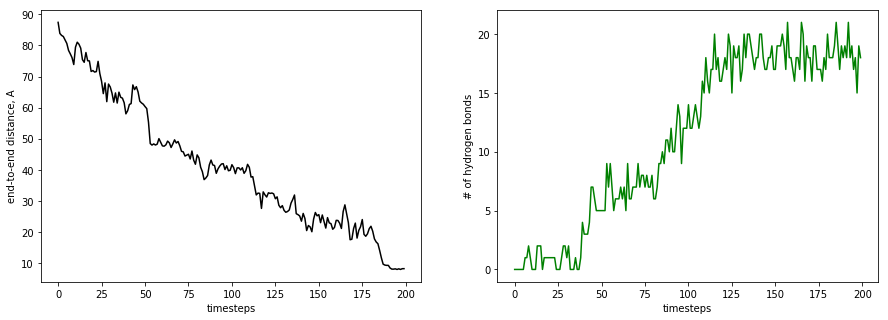

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot( dist, '-k' )
plt.xlabel('timesteps')
plt.ylabel('end-to-end distance, A')

plt.subplot(122)
plt.plot(hb_number, 'g-')
plt.ylabel('# of hydrogen bonds')
plt.xlabel('timesteps')

plt.show()

**[Ramachandran plot](https://en.wikipedia.org/wiki/Ramachandran_plot):**

/home/klyshko/anaconda3/lib/python3.6/site-packages/MDAnalysis/analysis/dihedrals.py:286: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


Text(30, 150, 'beta region')

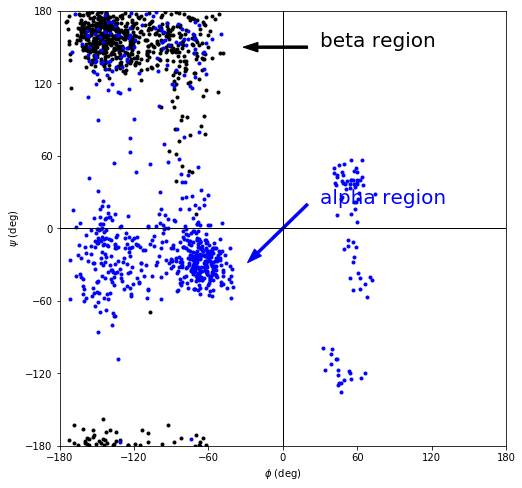

In [14]:
from MDAnalysis.analysis import dihedrals  ## module for dihedrals analysis

ram1 = dihedrals.Ramachandran(sys).run(0,30) ## analyse for first 30 steps (black color)
ram2 = dihedrals.Ramachandran(sys).run(170,200) ## analyse for last 30 steps (blue color)

## ramachandran plot
fig, ax = plt.subplots(figsize=(8,8))
ram1.plot(ax=ax, color='k', marker='.')
ram2.plot(ax=ax, color='b', marker='.')
ax.arrow(20, 20, -40, -40, width=2, head_width=8, head_length=12, fc='b', ec='b')
ax.text(30, 20, 'alpha region', color='blue', fontsize=20)
ax.arrow(20, 150, -40, 0, width=2, head_width=8, head_length=12, fc='k', ec='k')
ax.text(30, 150, 'beta region', fontsize=20)

<hr>

## Exercise 1. Simulation of a projectile.

<img src="pics/brady.JPG" width="15%" align='right'>
Read through sections 2-3 and example 3.1 of the lecture. Write a program that simulates the 2-s motion of the NFL ball ($m = 15$ ounces) thrown by quaterback [T.Brady](https://en.wikipedia.org/wiki/Tom_Brady) from height $H=8$ ft at speed $v=60$ MPH which is 30 degrees to the horizontal. Save the simulation as `brady.html`. 

**Hint**. Be careful with units. You need SI.

Use the cell below.

In [ ]:
## GO PATS!

## Exercise 2. Simulation of an N-body problem.

Read through sections 2-3 and example 3.2 of the lecture. Write a program that simulates the 10-s dynamics of **4** particles, each with $m = 0.5$ kg, connected to each other with invisible springs with $K_s = 8$ N/m, and $r_0 = 2$ m initially located at (0,0), (0, 2), (2, 0) and (2, 2) on the 2D plane. Save the simulation as `4body.html`.


Use the cell below.

## Exercise 3. Your first MD simulation.

Read through section 6 and example 6.1-6.2 of the lecture. Run 3 simulations of fully extended polyglycine `data/polyGLY.pdb` for 1 nanosecond in vacuum (no water) with $T_1=100 K$, $T_2=300 K$, and $T_3=500 K$ and visually compare how extended the final structure is at each temperature.  

## Exercise 4. MD simulation analysis.

Perform a quantitative analysis of the trajectories you obtained in Exercise 3. Use, for example, the end-to-end distance or the function `radius_of_gyration()` from the `MDAnalysis` module, which returns the [radius of gyration](https://en.wikipedia.org/wiki/Radius_of_gyration) of the protein.